# Store Item Demand Forecasting Challenge
>https://www.kaggle.com/c/demand-forecasting-kernels-only/overview






Best Score <br>
Experiment 6: Ensembled model (Improved Prophet + Tuned Catboost + Rounding) <br>
Rank 98/459 on private leaderboard (top 21%) <br>
Rank 119/459 on public leaderboard (top 25%) <br>
<br>
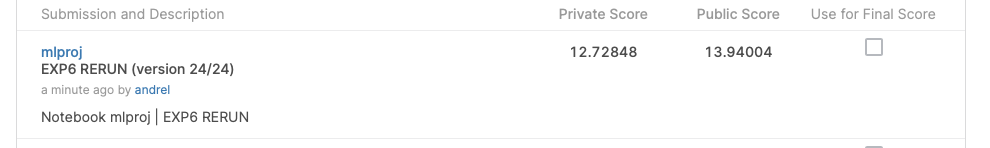

## Imports


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score

In [3]:
# train.csv
train_df = pd.read_csv("train.csv")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
# test.csv
test_df = pd.read_csv("test.csv")
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [5]:
# sample_submission.csv
sample_df = pd.read_csv("sample_submission.csv")
sample_df.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


Exploration

## Data Preparation

In [6]:
from datetime import datetime

def convertYMD(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = [i.year for i in df['date']]
    df['month'] = [i.month for i in df['date']]
    df['day'] = [i.dayofweek for i in df['date']]

# Baseline ML Models

In [7]:
train_df = pd.read_csv("train.csv")
train_df = train_df.reset_index()
train_df.rename(columns={'index': 'id'}, inplace=True)
train_df

,id,date,store,item,sales
0,0,2013-01-01,1,1,13
1,1,2013-01-02,1,1,11
2,2,2013-01-03,1,1,14
3,3,2013-01-04,1,1,13
4,4,2013-01-05,1,1,10
...,...,...,...,...,...
912995,912995,2017-12-27,10,50,63
912996,912996,2017-12-28,10,50,59
912997,912997,2017-12-29,10,50,74
912998,912998,2017-12-30,10,50,62


In [8]:
# split train_df into 2 validation and train set
val = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # first 3 months of 2017
train = pd.concat([train_df, val, val]).drop_duplicates(keep=False) # the rest of the months
val

,id,date,store,item,sales
1461,1461,2017-01-01,1,1,19
1462,1462,2017-01-02,1,1,15
1463,1463,2017-01-03,1,1,10
1464,1464,2017-01-04,1,1,16
1465,1465,2017-01-05,1,1,14
...,...,...,...,...,...
912720,912720,2017-03-27,10,50,66
912721,912721,2017-03-28,10,50,60
912722,912722,2017-03-29,10,50,73
912723,912723,2017-03-30,10,50,68


x-labels

In [9]:
convertYMD(train)
train.drop('date', axis=1, inplace=True)
train

,id,store,item,sales,year,month,day
0,0,1,1,13,2013,1,1
1,1,1,1,11,2013,1,2
2,2,1,1,14,2013,1,3
3,3,1,1,13,2013,1,4
4,4,1,1,10,2013,1,5
...,...,...,...,...,...,...,...
912995,912995,10,50,63,2017,12,2
912996,912996,10,50,59,2017,12,3
912997,912997,10,50,74,2017,12,4
912998,912998,10,50,62,2017,12,5


In [10]:
convertYMD(val)
val.drop('date', axis=1, inplace=True)
val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,id,store,item,sales,year,month,day
1461,1461,1,1,19,2017,1,6
1462,1462,1,1,15,2017,1,0
1463,1463,1,1,10,2017,1,1
1464,1464,1,1,16,2017,1,2
1465,1465,1,1,14,2017,1,3
...,...,...,...,...,...,...,...
912720,912720,10,50,66,2017,3,0
912721,912721,10,50,60,2017,3,1
912722,912722,10,50,73,2017,3,2
912723,912723,10,50,68,2017,3,3


y-labels

In [11]:
sales_val = val.pop('sales')
sales_val

1461      19
1462      15
1463      10
1464      16
1465      14
          ..
912720    66
912721    60
912722    73
912723    68
912724    69
Name: sales, Length: 45000, dtype: int64

In [12]:
sales_train = train.pop('sales')
sales_train

0         13
1         11
2         14
3         13
4         10
          ..
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 868000, dtype: int64

In [13]:
test_df

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [14]:
print(train.shape, val.shape, test_df.shape)

(868000, 6) (45000, 6) (45000, 4)


In [15]:
def regression_report(y_true, y_pred):
    metrics = [('SMAPE', (100/len(y_pred) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_pred) + np.abs(y_true))))),
               ('MAE', mean_absolute_error(y_true, y_pred)),
               ('Median Absolute Error', median_absolute_error(y_true, y_pred)),
               ('Mean Squared Error', mean_squared_error(y_true, y_pred)),
               ('Max Error', max_error(y_true, y_pred)),
               ('R2 Score', r2_score(y_true, y_pred)),
               ('Explained Variance Score', explained_variance_score(y_true, y_pred))]

    # Init scoring metrics
    regression_report_df = pd.DataFrame(columns=['Metric Name', 'Score'])
    dfs = []
    for name, score in metrics:
        df = pd.DataFrame([[name, score]], columns=['Metric Name', 'Score'])
        dfs.append(df)
    regression_report_df = pd.concat(dfs, ignore_index=True)
              
    return regression_report_df

## Catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', n_estimators = 200, eta = 0.3, random_seed=1)
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds = 20, eval_set=(val.values, sales_val.values))

C:\Users\nct\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

  from pandas import MultiIndex, Int64Index


0:	learn: 25.5508294	test: 22.0294744	best: 22.0294744 (0)	total: 298ms	remaining: 59.2s

1:	learn: 23.5569327	test: 20.0034748	best: 20.0034748 (1)	total: 403ms	remaining: 39.9s

2:	learn: 21.9270142	test: 18.7698309	best: 18.7698309 (2)	total: 507ms	remaining: 33.3s

3:	learn: 20.8556084	test: 17.8652701	best: 17.8652701 (3)	total: 628ms	remaining: 30.8s

4:	learn: 19.8948580	test: 17.1182411	best: 17.1182411 (4)	total: 760ms	remaining: 29.6s

5:	learn: 18.9128838	test: 16.1631390	best: 16.1631390 (5)	total: 920ms	remaining: 29.7s

6:	learn: 18.1926212	test: 15.4094859	best: 15.4094859 (6)	total: 1.17s	remaining: 32.2s

7:	learn: 17.6572749	test: 14.9678126	best: 14.9678126 (7)	total: 1.33s	remaining: 31.9s

8:	learn: 16.4071182	test: 13.7564503	best: 13.7564503 (8)	total: 1.48s	remaining: 31.4s

9:	learn: 15.3101600	test: 12.6974150	best: 12.6974150 (9)	total: 1.61s	remaining: 30.5s

10:	learn: 14.5357008	test: 11.9557628	best: 11.9557628 (10)	total: 1.73s	remaining: 29.7s

11:	lear

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,13.470677
1,MAE,5.308890
2,Median Absolute Error,4.244043
3,Mean Squared Error,47.227441
4,Max Error,36.376568
5,R2 Score,0.916615
6,Explained Variance Score,0.916844


In [ ]:
y_pred = model.predict(test_df.values)

sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_cb.csv", index=False)
sample_df.head()

,id,sales
0,0,12.024849
1,1,13.822182
2,2,13.872539
3,3,14.491420
4,4,15.831704


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(train.values, sales_train.values)

DecisionTreeRegressor()

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.971560
1,MAE,5.914089
2,Median Absolute Error,4.750000
3,Mean Squared Error,59.487114
4,Max Error,46.250000
5,R2 Score,0.894970
6,Explained Variance Score,0.899911


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_dt.csv", index=False)
sample_df.head()

,id,sales
0,0,10.25
1,1,15.00
2,2,13.00
3,3,14.75
4,4,15.40


## LightGBM

In [ ]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds=20, eval_set=(val.values, sales_val.values))

C:\Users\nct\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\nct\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 584.19

[2]	valid_0's l2: 561.64

[3]	valid_0's l2: 524.281

[4]	valid_0's l2: 506.43

[5]	valid_0's l2: 473.732

[6]	valid_0's l2: 450.229

[7]	valid_0's l2: 428.166

[8]	valid_0's l2: 416.79

[9]	valid_0's l2: 394.807

[10]	valid_0's l2: 374.03

[11]	valid_0's l2: 363.919

[12]	valid_0's l2: 361.482

[13]	valid_0's l2: 342.619

[14]	valid_0's l2: 330.144

[15]	valid_0's l2: 300.307

[16]	valid_0's l2: 297.294

[17]	valid_0's l2: 268.072

[18]	valid_0's l2: 257.175

[19]	valid_0's l2: 254.052

[20]	valid_0's l2: 247.8

[21]	valid_0's l2: 225.654

[22]	valid_0's l2: 227.765

[23]	valid_0's l2: 223.403

[24]	valid_0's l2: 217.933

[25]	valid_0's l2: 214.066

[26]	valid_0's l2: 204.363

[27]	valid_0's l2: 202.691

[28]	valid_0's l2: 198.104

[29]	valid_0's l2: 199.247

[30]	valid_0's l2: 196.216

[31]	valid_0's l2: 181.023

[32]	valid_0's l2: 176.559

[33]	valid_0's l2: 174.482

[34]	valid_0's l2: 163.458

[35]	valid_0's l2: 158.113

[36]	valid_0's l2: 154.468

[37]	val

LGBMRegressor()

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,16.073213
1,MAE,6.260856
2,Median Absolute Error,5.224466
3,Mean Squared Error,63.384272
4,Max Error,49.278440
5,R2 Score,0.888089
6,Explained Variance Score,0.892342


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_lgbm.csv", index=False)
sample_df.head()

,id,sales
0,0,16.561062
1,1,17.444016
2,2,17.444016
3,3,18.268907
4,4,17.977213


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train.values, sales_train.values)

LinearRegression()

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,48.924073
1,MAE,22.670578
2,Median Absolute Error,21.663495
3,Mean Squared Error,717.115720
4,Max Error,90.322757
5,R2 Score,-0.266139
6,Explained Variance Score,0.066234


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_lr.csv", index=False)
sample_df.head()

,id,sales
0,0,57.005051
1,1,60.219296
2,2,63.433540
3,3,66.647785
4,4,69.862029


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, n_jobs=-1)
model.fit(train.values, sales_train.values)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.939864
1,MAE,5.903299
2,Median Absolute Error,4.701825
3,Mean Squared Error,59.287404
4,Max Error,45.934653
5,R2 Score,0.895322
6,Explained Variance Score,0.900283


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_rf.csv", index=False)
sample_df.head()

,id,sales
0,0,10.285578
1,1,14.938321
2,2,12.882200
3,3,14.679198
4,4,15.437772


## XGBoost

In [ ]:
import xgboost
model = xgboost.XGBRegressor(n_estimators = 200, seed = 21)
model.fit(train.values, sales_train.values, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=21,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.064043
1,MAE,5.522580
2,Median Absolute Error,4.433034
3,Mean Squared Error,50.913739
4,Max Error,38.642258
5,R2 Score,0.910107
6,Explained Variance Score,0.910661


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_xgb.csv", index=False)
sample_df.head()

,id,sales
0,0,14.757501
1,1,16.119011
2,2,16.984201
3,3,13.956003
4,4,15.874704


## MLP (Neural Network)

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(32,32,32), activation="relu", random_state=1, max_iter=20).fit(train.values, sales_train.values)

C:\Users\nct\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.

  warnings.warn(


In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,37.410320
1,MAE,15.518736
2,Median Absolute Error,12.422675
3,Mean Squared Error,406.063925
4,Max Error,102.058914
5,R2 Score,0.283054
6,Explained Variance Score,0.323098


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_mlp.csv", index=False)
sample_df.head()

,id,sales
0,0,4.529868
1,1,5.776620
2,2,7.023372
3,3,8.831623
4,4,10.765563


# Prophet

In [16]:
# !pip install prophet
# !pip install --upgrade plotly
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

In [63]:
train = train_df.loc[(train_df["date"] < "2017-01-01"), :] # everything else before that
train['date'] = pd.to_datetime(train['date'])
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
test['date'] = pd.to_datetime(test['date'])

results = test.reset_index()
results['sales'] = 0 # init sales col

result_df = pd.DataFrame(columns = ['sales'])

stores = train['store'].unique()
items = train['item'].unique()
period = len(test.index.unique())

# run the model through each of the 10 stores and 50 items
for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y']) # log transform
        
        model = Prophet()
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat']
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
11:26:08 - cmdstanpy - INFO - Chain [1] start processing
11:26:08 - cmdstanpy - INFO - Chain [1] done processing
11:26:09 - cmdstanpy - INFO - Chain [1] start processing
11:26:09 - cmdstanpy - INFO - Chain [1] done processing
11:26:10 - cmdstanpy - INFO

In [64]:
result_df.head()

,sales,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,3.012006,2017-01-01,3.121067,2.722092,3.319723,3.121067,3.121067,-0.109061,-0.109061,-0.109061,0.178424,0.178424,0.178424,-0.287485,-0.287485,-0.287485,0.0,0.0,0.0,3.012006
1,2.605860,2017-01-02,3.121271,2.314068,2.904543,3.121271,3.121271,-0.515410,-0.515410,-0.515410,-0.227879,-0.227879,-0.227879,-0.287531,-0.287531,-0.287531,0.0,0.0,0.0,2.605860
2,2.752642,2017-01-03,3.121475,2.465390,3.027004,3.121475,3.121475,-0.368833,-0.368833,-0.368833,-0.080215,-0.080215,-0.080215,-0.288618,-0.288618,-0.288618,0.0,0.0,0.0,2.752642
3,2.783850,2017-01-04,3.121678,2.507492,3.084206,3.121678,3.121678,-0.337829,-0.337829,-0.337829,-0.047165,-0.047165,-0.047165,-0.290664,-0.290664,-0.290664,0.0,0.0,0.0,2.783850
4,2.800618,2017-01-05,3.121882,2.510337,3.112551,3.121882,3.121882,-0.321265,-0.321265,-0.321265,-0.027708,-0.027708,-0.027708,-0.293557,-0.293557,-0.293557,0.0,0.0,0.0,2.800618


In [65]:
val = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
val = val.reset_index()
val.sales

0        19
1        15
2        10
3        16
4        14
         ..
44995    66
44996    60
44997    73
44998    68
44999    69
Name: sales, Length: 45000, dtype: int64

In [66]:
regression_report(val.sales, result_df['sales'])

,Metric Name,Score
0,SMAPE,161.341230
1,MAE,42.047173
2,Median Absolute Error,38.530493
3,Mean Squared Error,2329.328461
4,Max Error,156.645397
5,R2 Score,-3.112660
6,Explained Variance Score,0.008833


In [21]:
df = result_df['sales']
df2 = pd.DataFrame(df)
df2.columns.values[0] = "id"
df2

,id
0,21.162305
1,13.232890
2,15.839909
3,16.355516
4,16.741855
...,...
44995,68.076399
44996,77.564330
44997,78.634312
44998,83.450371


In [22]:
df2 = result_df['sales']
df2 = df2.reset_index()
df2.rename(columns={'index': 'id'}, inplace=True)
df2.to_csv('submission1.csv', index=False)


## Improving Prophet: With Prophet built in holidays

In [67]:
train = train_df.loc[(train_df["date"] < "2017-01-01"), :] # everything else before that
train['date'] = pd.to_datetime(train['date'])
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
test['date'] = pd.to_datetime(test['date'])

results = test.reset_index()
results['sales'] = 0

result_df = pd.DataFrame(columns = ['sales'])

stores = train_df['store'].unique()
items = train_df['item'].unique()

# run the model through each of the 10 stores and 50 items
for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y']) # log transform
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.add_country_holidays(country_name='US')
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat']
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO

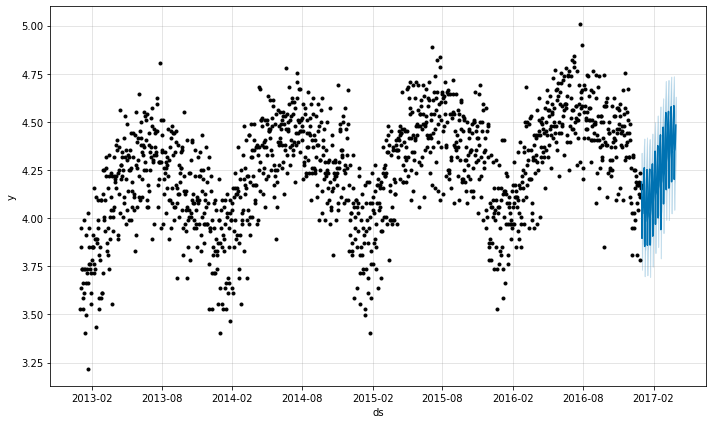

In [68]:
forecastplot = model.plot(forecast)

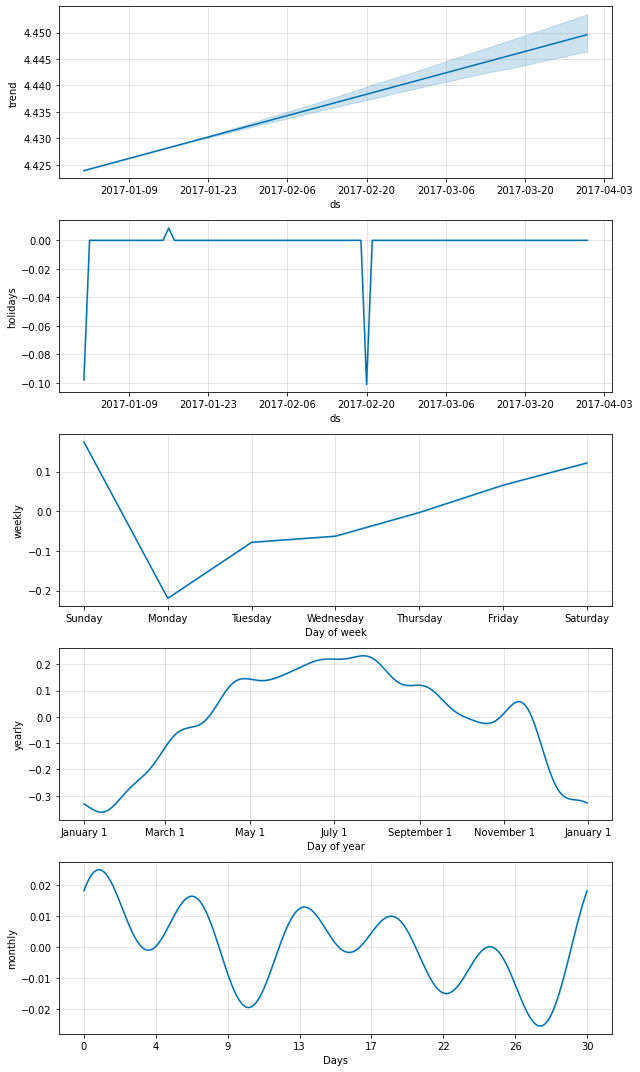

In [69]:
fig = model.plot_components(forecast)

In [70]:
test_results = result_df['sales']
test_results = np.round(test_results).astype(int) 

In [84]:
regression_report(val.sales, test_results)

,Metric Name,Score
0,SMAPE,161.486983
1,MAE,42.063444
2,Median Absolute Error,39.000000
3,Mean Squared Error,2330.674778
4,Max Error,157.000000
5,R2 Score,-3.115037
6,Explained Variance Score,0.008870


In [28]:
# rounded off results is better than non-rounded
df2 = test_results
df2 = df2.reset_index()
df2.rename(columns={'index': 'id'}, inplace=True)
df2
df2.to_csv('submission2.csv', index=False) 

In [72]:
model.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11    Independence Day (Observed)
dtype: object

## Improving Prophet: With holiday dataset from Kaggle

In [73]:
holidays = pd.read_csv("US Holiday Dates (2004-2021).csv")
holidays.head()

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008


In [74]:
holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True)
holidays['ds'] = pd.to_datetime(holidays['ds']) 
holidays = holidays[(holidays['ds']>holidays.iloc[0]['ds'])&(holidays['ds']<holidays.iloc[-1]['ds'])]
results = test.reset_index()
results['sales'] = 0
period = len(test.index.unique())

In [75]:
train = train_df.loc[(train_df["date"] < "2017-01-01"), :] # everything else before that
train['date'] = pd.to_datetime(train['date'])
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
test['date'] = pd.to_datetime(test['date'])

results = test.reset_index()
results['sales'] = 0

result_df = pd.DataFrame(columns = ['sales'])

stores = train_df['store'].unique()
items = train_df['item'].unique()

for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y']) # log transform
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat']
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)
       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
12:13:42 - cmdstanpy - INFO - Chain [1] start processing
12:13:42 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO

In [76]:
result_df['sales'] = np.round(result_df['sales']) # round to whole number
df2 = result_df['sales']
df2 = df2.reset_index()
df2.rename(columns={'index': 'id'}, inplace=True)
df2.to_csv('submission3.csv', index=False) 

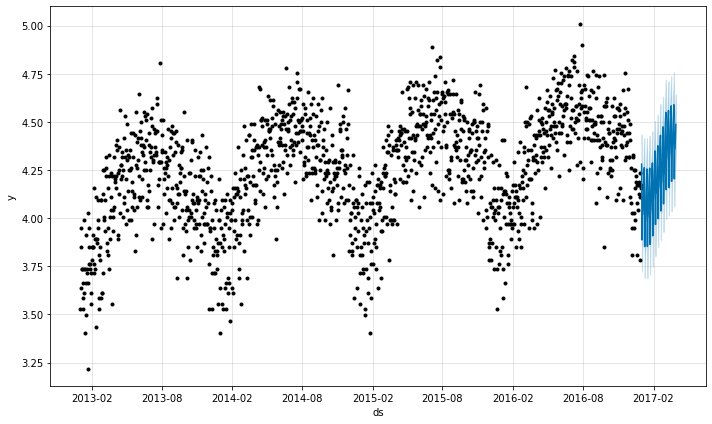

In [77]:
forecastplot = model.plot(forecast)

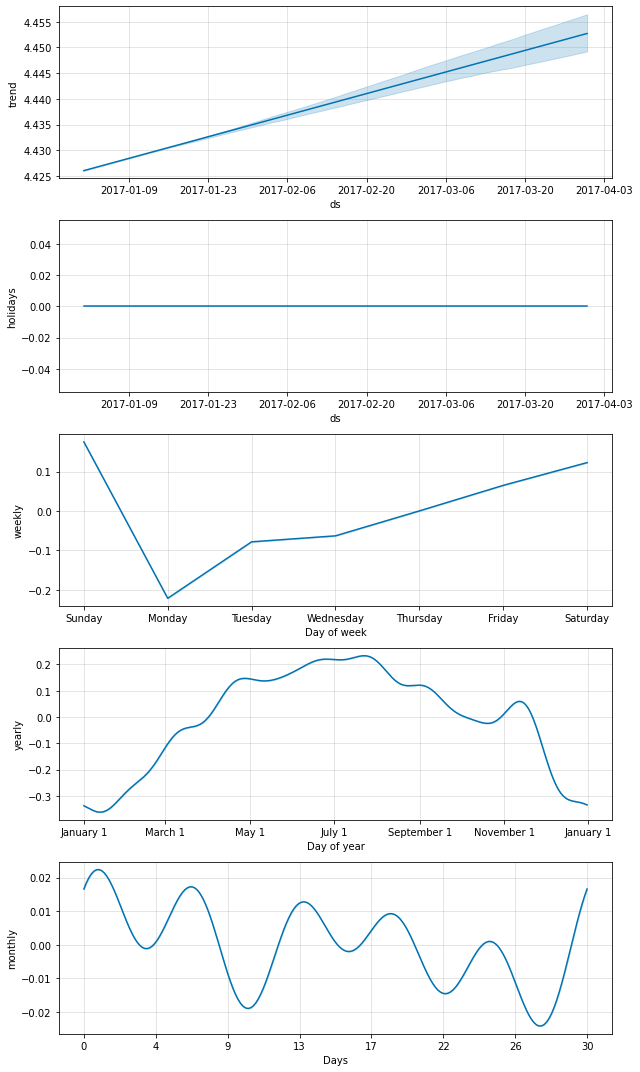

In [78]:
fig = model.plot_components(forecast)

In [81]:
test_results = result_df['sales']
test_results

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
44995    4.0
44996    4.0
44997    4.0
44998    4.0
44999    4.0
Name: sales, Length: 45000, dtype: float64

In [85]:
regression_report(val.sales, test_results)

,Metric Name,Score
0,SMAPE,161.486983
1,MAE,42.063444
2,Median Absolute Error,39.000000
3,Mean Squared Error,2330.674778
4,Max Error,157.000000
5,R2 Score,-3.115037
6,Explained Variance Score,0.008870


## Improving Prophet: Seasonality (fourier order 3 instead of 5)

In [86]:
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :]
results = test.reset_index()
results['sales']
period = len(test.index.unique())

for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y'])
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=3)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat'].values
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)
        

12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing
12:33:07 - cmdstanpy - INFO - Chain [1] start processing
12:33:08 - cmdstanpy - INFO - Chain [1] done processing
12:33:08 - cmdstanpy - INFO - Chain [1] start processing
12:33:08 - cmdstanpy - INFO - Chain [1] done processing
12:33:09 - cmdstanpy - INFO - Chain [1] start processing
12:33:09 - cmdstanpy - INFO - Chain [1] done processing
12:33:10 - cmdstanpy - INFO - Chain [1] start processing
12:33:10 - cmdstanpy - INFO - Chain [1] done processing
12:33:11 - cmdstanpy - INFO - Chain [1] start processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:13 - cmdstanpy - INFO - Chain [1] start processing
12:33:13 - cmdstanpy - INFO - Chain [1] done processing
12:33:14 - cmdstanpy - INFO - Chain [1] start processing
12:33:15 - cmdstanpy - INFO - Chain [1]

In [87]:
results.drop(['date', 'store', 'item', 'index'], axis=1, inplace=True)
results

,id,sales
0,1461,3.008680
1,1462,2.602626
2,1463,2.749148
3,1464,2.780222
4,1465,2.797338
...,...,...
44995,912720,4.197370
44996,912721,4.342945
44997,912722,4.361753
44998,912723,4.430499


In [88]:
results.to_csv('submission4.csv', index=False)

In [89]:
# rounding
results['sales'] = np.round(results['sales']).astype(int)
test_results = results['sales']
results.to_csv('submission5.csv', index=False)

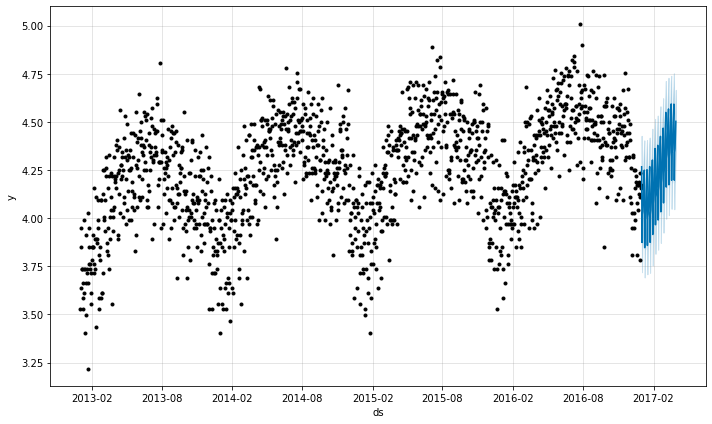

In [90]:
forecastplot = model.plot(forecast)

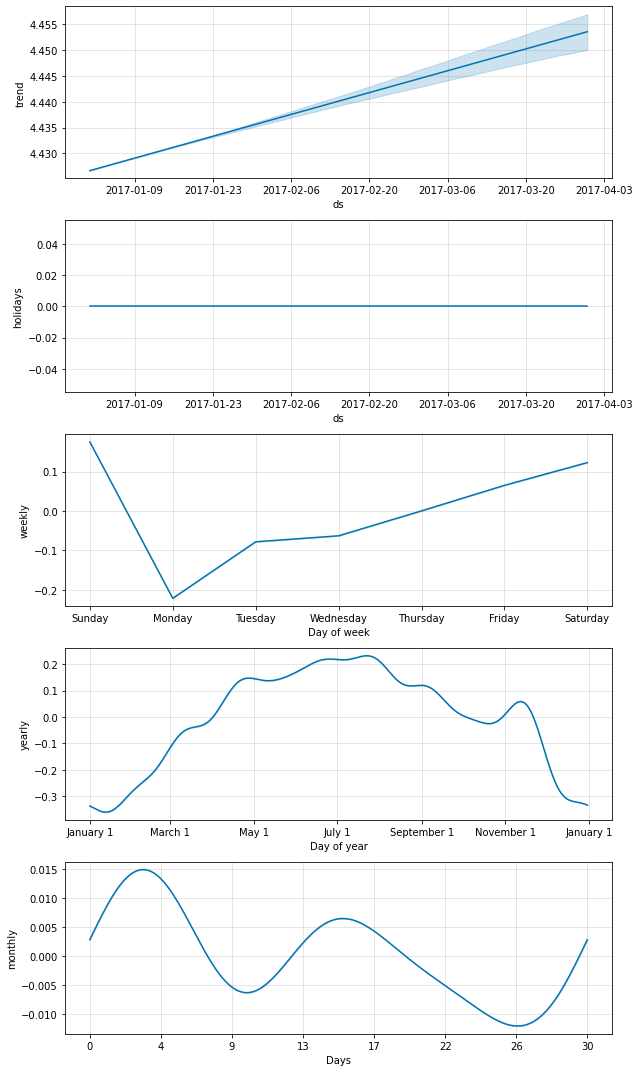

In [91]:
fig = model.plot_components(forecast)

In [92]:
regression_report(val.sales, test_results)

,Metric Name,Score
0,SMAPE,163.109948
1,MAE,42.063200
2,Median Absolute Error,38.000000
3,Mean Squared Error,2313.815956
4,Max Error,156.000000
5,R2 Score,-3.085271
6,Explained Variance Score,0.038626


# Proposed Solution

## Retraining Best Baseline Model - Catboost


> Previously, the baseline models were trained on segmented data to evaluate the performance of each model. As Prophet was trained with the entire training dataset provided without splitting, the catboost model will be trained here in entirety. 



In [1]:
!pip install catboost

In [53]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', n_estimators = 200, eta = 0.3, random_seed=1)
model.fit(train_df.values, sales.values, verbose=True, early_stopping_rounds = 20)

NameError: ignored

In [ ]:
y_pred = model.predict(test_df.values)

In [ ]:
# init sample_submission.csv
sample_df = pd.read_csv("https://drive.google.com/uc?id=1VUhb4Jv2BbeE3jLef3vuTMhWDnf3z_JD")
sample_df['sales'] = y_pred
sample_df.head()

In [ ]:
sample_df.to_csv("submission_catboost.csv", index=False)

## Ensembling Experiments (Before Tuning)

Experiment 1 (without rounding)

In [ ]:
# both df had no rounding
import pandas as pd
df1 = pd.read_csv("/content/submission_catboost.csv")
df2 = pd.read_csv("/content/submission_prophet_1.csv")

In [ ]:
df1.head(3)

In [ ]:
df2.head(3)

In [ ]:
df3 = df1 # make a duplicate
df3['sales'] = (0.5*df1['sales']) + (0.5*df2['sales'])

In [ ]:
df3

In [ ]:
df3.to_csv('/content/submission_ens.csv', index=False) 

Experiment 2 (with rounding)

In [ ]:
import numpy as np
df4 = df3
df4['sales'] = np.round(df4['sales']).astype(int) # round the result to whole number

In [ ]:
df4

In [ ]:
df4.to_csv('/content/submission_ens2.csv', index=False)

Experiment 3 (changing weightage p1)

In [ ]:
df5 = df1 # make a duplicate
df5['sales'] = (0.4*df1['sales']) + (0.6*df2['sales'])

In [ ]:
df5

Experiment 4 (changing weightage p2)

In [ ]:
df6 = df1 # make a duplicate
df6['sales'] = (0.6*df1['sales']) + (0.4*df2['sales'])

In [ ]:
df6

In [ ]:
df6.to_csv('/content/submission_ens4.csv', index=False)

In [ ]:
import numpy as np
df6_rounded = df6
df6_rounded['sales'] = np.round(df6_rounded['sales']).astype(int) # round the result to whole number

In [ ]:
df6_rounded

In [ ]:
df6_rounded.to_csv('/content/submission_ens4_rounded.csv', index=False)

## Improving Catboost

In [ ]:
!pip install catboost

Gridsearch, 3-fold cross validation

In [ ]:
from catboost import CatBoostRegressor
import numpy as np

model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1, 0.3],
        'max_depth': [8, 10, 12],
        'n_estimators': [100, 200, 300]}

grid_search_result = model.grid_search(grid, cv=3,
                                       X=train_df.values,
                                       y=sales.values,
                                       plot=True)

In [ ]:
grid_search_result['params']

Results based on the best parameters

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', eval_metric='SMAPE', n_estimators = 300, learning_rate = 0.3, random_seed=1)
model.fit(train_df.values, sales.values, verbose=True, early_stopping_rounds=20)

In [ ]:
y_pred = model.predict(test_df.values)

In [ ]:
# init sample_submission.csv
sample_df = pd.read_csv("https://drive.google.com/uc?id=1VUhb4Jv2BbeE3jLef3vuTMhWDnf3z_JD")
sample_df['sales'] = y_pred
sample_df.head()

In [ ]:
sample_df.to_csv("submission_catboost_2.csv", index=False)

In [ ]:
sample_df

Results based on the best parameters (different random seed)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', eval_metric='SMAPE', n_estimators = 300, learning_rate = 0.3, random_seed=21)
model.fit(train_df.values, sales.values, verbose=True, early_stopping_rounds=20)

In [ ]:
y_pred = model.predict(test_df.values)

In [ ]:
# init sample_submission.csv
sample_df = pd.read_csv("https://drive.google.com/uc?id=1VUhb4Jv2BbeE3jLef3vuTMhWDnf3z_JD")
sample_df['sales'] = y_pred
sample_df.head()

In [ ]:
sample_df.to_csv("submission_catboost_3.csv", index=False)

In [ ]:
sample_df

## Improving Prophet

In [2]:
# !pip install fbprophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation
import numpy as np

In [3]:
import pandas as pd
# train.csv
train_df = pd.read_csv("train.csv")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
train_df.rename(columns = {'date':'ds', 'sales':'y'}, inplace = True)

Included unofficial holidays like black friday

In [6]:
holidays = pd.read_csv("Holiday_updated.csv")
holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True)
holidays['ds'] = pd.to_datetime(holidays['ds']) 
holidays

,ds,holiday,WeekDay,Month,Day,Year
0,2004-04-07,4th of July,Sunday,7,4,2004
1,2005-04-07,4th of July,Monday,7,4,2005
2,2006-04-07,4th of July,Tuesday,7,4,2006
3,2007-04-07,4th of July,Wednesday,7,4,2007
4,2008-04-07,4th of July,Friday,7,4,2008
...,...,...,...,...,...,...
427,2017-11-27,Cyber Monday Sales,Monday,11,27,2017
428,2018-11-26,Cyber Monday Sales,Monday,11,26,2018
429,2019-02-12,Cyber Monday Sales,Monday,12,2,2019
430,2020-11-30,Cyber Monday Sales,Monday,11,30,2020


Seasonality

In [11]:
train = pd.read_csv("train.csv", parse_dates=['date'], index_col=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'], index_col=['date'])

results = test.reset_index()
results['sales'] = 0

stores = train_df['store'].unique()
items = train_df['item'].unique()

for s in stores :
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y'])
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=3)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=len(test.index.unique()), include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = np.expm1(forecast['yhat']).values
        

13:48:46 - cmdstanpy - INFO - Chain [1] start processing
13:48:46 - cmdstanpy - INFO - Chain [1] done processing
13:48:47 - cmdstanpy - INFO - Chain [1] start processing
13:48:47 - cmdstanpy - INFO - Chain [1] done processing
13:48:48 - cmdstanpy - INFO - Chain [1] start processing
13:48:49 - cmdstanpy - INFO - Chain [1] done processing
13:48:50 - cmdstanpy - INFO - Chain [1] start processing
13:48:50 - cmdstanpy - INFO - Chain [1] done processing
13:48:51 - cmdstanpy - INFO - Chain [1] start processing
13:48:51 - cmdstanpy - INFO - Chain [1] done processing
13:48:52 - cmdstanpy - INFO - Chain [1] start processing
13:48:52 - cmdstanpy - INFO - Chain [1] done processing
13:48:53 - cmdstanpy - INFO - Chain [1] start processing
13:48:54 - cmdstanpy - INFO - Chain [1] done processing
13:48:55 - cmdstanpy - INFO - Chain [1] start processing
13:48:55 - cmdstanpy - INFO - Chain [1] done processing
13:48:56 - cmdstanpy - INFO - Chain [1] start processing
13:48:56 - cmdstanpy - INFO - Chain [1]

In [15]:
results.drop(['date', 'store', 'item'], axis=1, inplace=True)
results
results.to_csv('submission6.csv', index=False)

In [21]:
results

,id,sales
0,0,13
1,1,14
2,2,15
3,3,16
4,4,17
...,...,...
44995,44995,72
44996,44996,73
44997,44997,78
44998,44998,84


In [17]:
results['sales'] = np.round(results['sales']).astype(int) # round the result to whole number
results.to_csv('submission7.csv', index=False)

In [22]:
results

,id,sales
0,0,13
1,1,14
2,2,15
3,3,16
4,4,17
...,...,...
44995,44995,72
44996,44996,73
44997,44997,78
44998,44998,84


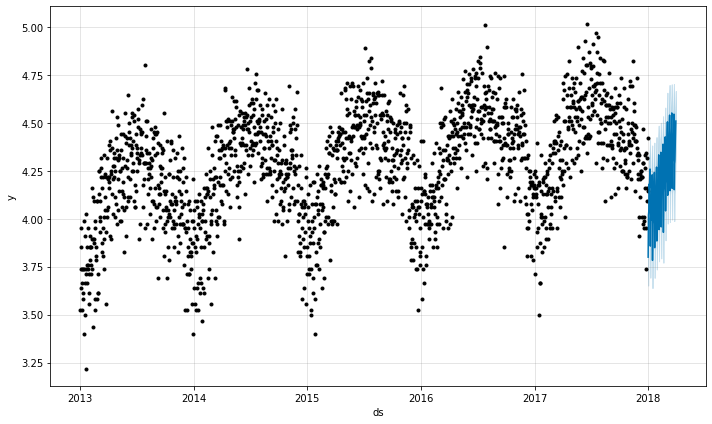

In [19]:
forecastplot = model.plot(forecast)

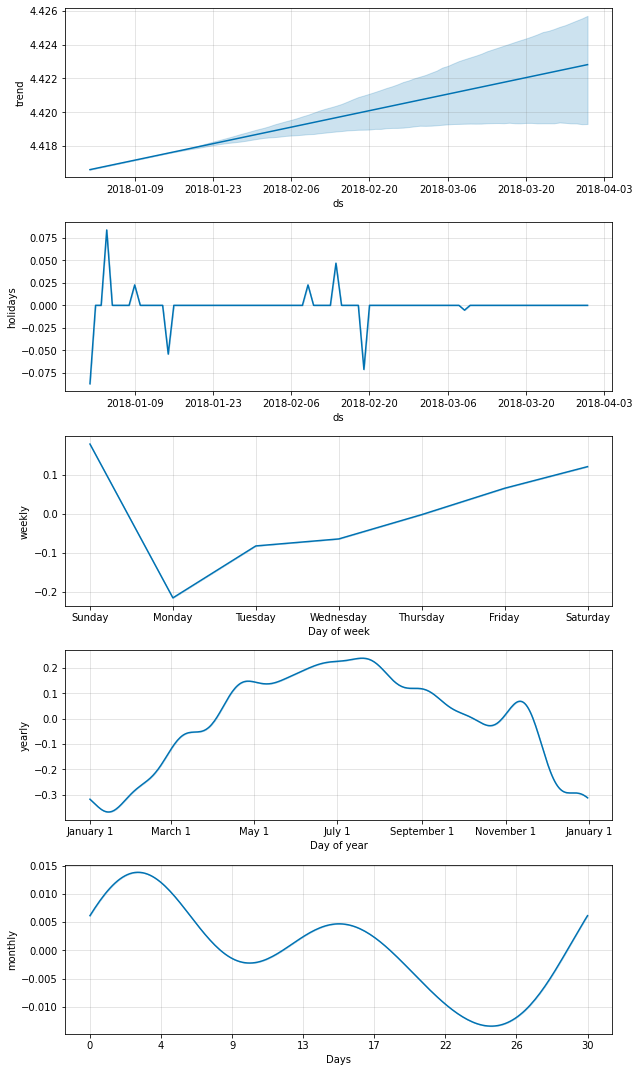

In [20]:
fig = model.plot_components(forecast)

## Ensembling Experiments (After Tuning)


> The improved catboost and Prophet models showed improvement to forecasting accuracy (observed in Experiment 6) - especially with a custom ratio of weighted average (60% catboost 40% prophet instead of 50-50 in Experiment 9). From ensembled learning before tuning, rounded sales figures showed better SMAPE scores, which is also applied for all experiments below. Experiment 10 showed that the ensembling of all 5 models did not produce the best result, possibly due to higher inaccuracies in forecasting for the pre-tuned models.



In [ ]:
import pandas as pd
df1_1 = pd.read_csv("/content/submission_catboost.csv")
df1_2 = pd.read_csv("/content/submission_catboost_2.csv")
df1_3 = pd.read_csv("/content/submission_catboost_3.csv")
df2_1 = pd.read_csv("/content/submission_prophet_1.csv")
df2_2 = pd.read_csv("/content/submission_prophet_2.csv")

exp_df = df1_1 # make a duplicate for experiments

Experiment 5

In [ ]:
exp_df['sales'] = (0.6*df1_1['sales']) + (0.4*df2_1['sales'])
exp_df.to_csv('/content/submission_ens5.csv', index=False)
exp_df

In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens5_rounded.csv', index=False)
exp_df_rounded

Experiment 6 - BEST

In [ ]:
exp_df['sales'] = (0.6*df1_2['sales']) + (0.4*df2_2['sales'])
exp_df

In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int)
exp_df.to_csv('/content/submission_ens6_rounded-2.csv', index=False)
exp_df_rounded

Experiment 7 - SECOND BEST

In [ ]:
exp_df['sales'] = (0.6*df1_2['sales']) + (0.4*df2_1['sales'])
exp_df

In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df.to_csv('/content/submission_ens7_rounded_v2.csv', index=False)
exp_df_rounded

Experiment 8

In [ ]:
exp_df['sales'] = (0.6*df1_3['sales']) + (0.4*df2_1['sales'])
exp_df

In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens8_rounded.csv', index=False)
exp_df_rounded

Experiment 9

In [ ]:
exp_df['sales'] = (0.5*df1_2['sales']) + (0.5*df2_2['sales'])
exp_df

In [ ]:
import numpy as np
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens9_rounded.csv', index=False)
exp_df_rounded

Experiment 10

In [ ]:
exp_df['sales'] = (0.45*((df1_1['sales']+df1_2['sales']+df1_3['sales'])/3)) + (0.55*(((0.5*df2_1['sales'])+(0.5*df2_2['sales']))))
exp_df

In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens10_rounded.csv', index=False)
exp_df_rounded